In [16]:
import dill
import jupyter_contrib_nbextensions

In [17]:
#import all utilities imports
import matplotlib as mp, pandas as pd, numpy as np, geopandas as gpd
import functools
import math
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pysal as ps
import random
import pylab
import matplotlib.colors as cols
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point, LineString, MultiLineString
from numpy.random import randn
from scipy import sparse
from scipy.sparse import linalg
import matplotlib.patches as mpatches
import sys
from time import sleep
pd.set_option('precision', 10)
from mpl_toolkits.mplot3d.art3d import Line3DCollection

#import all street network fuctions imports
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import functools
import community
import math
from math import sqrt
import matplotlib.pyplot as plt
import ast

from scipy import sparse
from scipy.sparse import linalg
import pysal as ps

from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping, MultiLineString
from shapely.ops import cascaded_union, linemerge, nearest_points
pd.set_option('precision', 10)

#import computational notebook functions
import networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import community
import matplotlib.pyplot as plt
from importlib import reload
import geopandas as gpd
import functools
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import street_network_functions as snf
import utilities as uf

In [60]:
#initialise path, names, etc.

city_name = 'Valencia'
import_path ='dataComp/'+'Valencia'+'/'
saving_path ='dataComp/'+city_name+'/'
epsg = 4326
crs = {'init': 'epsg:4326', 'no_defs': True}

## 1. create dual graph

In [19]:
dill.load_session('CreatePrimalGraphN1.db')

In [20]:
edgesW.head()

,u,v,key,streetID,geometry,length,highway,oneway,pedestrian,grade,grade_abs,name,hasBikeP,slopeCost,weightP1,weightP2,weightP3
0,2,5442,0,6,"LINESTRING (-0.35455 39.47602, -0.35442 39.47629)",32.128,cycleway,0,0,0.016,0.016,NaN,1,10.884,7.171,10.884,10.884
1,2,6,0,7,"LINESTRING (-0.35455 39.47602, -0.35462 39.47588)",16.423,cycleway,0,0,-0.013,0.013,NaN,1,3.666,3.666,3.666,3.666
2,2,6551,0,8,"LINESTRING (-0.35455 39.47602, -0.35497 39.476...",65.709,primary,1,0,0.025,0.025,Avinguda de Blasco Ibáñez,0,26.884,14.667,26.884,29.513
3,3,3542,0,9,"LINESTRING (-0.39384 39.45899, -0.39386 39.459...",47.111,pedestrian,0,1,0.013,0.013,Carrer d'En Galceràn,0,15.017,10.516,15.017,16.902
4,3,4568,0,10,"LINESTRING (-0.39384 39.45899, -0.39353 39.458...",42.766,pedestrian,0,1,0.008,0.008,NaN,0,12.080,9.546,12.080,13.791


In [21]:
nodesEG.head()

,nodeID,x,y,geometry,elevation
2,2,-0.355,39.476,POINT (-0.35455 39.47602),9.304
3,3,-0.394,39.459,POINT (-0.39384 39.45899),18.489
4,4,-0.343,39.481,POINT (-0.34340 39.48101),6.834
6,6,-0.355,39.476,POINT (-0.35462 39.47588),9.094
8,8,-0.373,39.463,POINT (-0.37266 39.46254),12.923


In [22]:
def dual_gdf(nodes_gdf, edges_gdf, crs):
    """
    It creates two dataframes that are supposed to generate the dual graph of a street network. The nodes_dual gdf contains edges 
    centroids, the edges_dual gdf, instead, contains links between the street segment centroids. Those dual edges link real street segment 
    that share a junction. The centroids are stored with the original edge streetID, while the dual edges are associated with several
    attributes computed on the original street segments (distance between centroids, deflection angle).
    
    Parameters
    ----------
    nodes_gdf, edges_gdf: GeoDataFrames, nodes and street segments  
    crs: dictionary
    
    Returns
    -------
    GeoDataFrames
    """
    if list(edges_gdf.index.values) != list(edges_gdf.streetID.values): edges_gdf.index =  edges_gdf.streetID
    
    # computing centroids                                       
    centroids_gdf = edges_gdf.copy()
    centroids_gdf['centroid'] = centroids_gdf['geometry'].centroid
    centroids_gdf['intersecting'] = None

    
    index_u = centroids_gdf.columns.get_loc("u")+1
    index_v = centroids_gdf.columns.get_loc("v")+1
    index_streetID = centroids_gdf.columns.get_loc("streetID")+1
         
    # find_intersecting segments and storing them in the centroids gdf
    processed = []
    for c in centroids_gdf.itertuples():
        intersections = []
        from_node = c[index_u]
        to_node = c[index_v]
    
        possible_intersections = centroids_gdf.loc[(centroids_gdf['u'] == from_node) |
                        (centroids_gdf['u'] == to_node) |
                        (centroids_gdf['v'] == to_node) |
                        (centroids_gdf['v'] == from_node)]

        for p in possible_intersections.itertuples():
            if ((c[0]==p[0]) | ((c[0], p[0]) in processed) | ((p[0], c[0]) in processed)): continue
        
            else:
                intersections.append(p[index_streetID])  # appending streetID
                processed.append((p[0],c[0]))
    
        centroids_gdf.set_value(c[0],'intersecting', intersections)
        
    # creating vertexes representing street segments (centroids)
    centroids_data = centroids_gdf[['streetID', 'intersecting', 'length','grade', 'grade_abs', 'name', 'slopeCost', 'hasBikeP', 'weightP1', 'weightP2', 'weightP3']]
    geometry = centroids_gdf['centroid']
    nodes_dual = gpd.GeoDataFrame(centroids_data, crs=crs, geometry=geometry)
    nodes_dual['x'] = [x.coords.xy[0][0] for x in centroids_gdf['centroid']]
    nodes_dual['y'] = [y.coords.xy[1][0] for y in centroids_gdf['centroid']]
    
    # creating fictious links between centroids
    edges_dual = pd.DataFrame(columns=['u','v', 'geometry', 'length'])

    index_length = nodes_dual.columns.get_loc("length")+1
    index_streetID_nd = nodes_dual.columns.get_loc("streetID")+1
    index_intersecting = nodes_dual.columns.get_loc("intersecting")+1
    index_geo = nodes_dual.columns.get_loc("geometry")+1
    
    # connecting nodes which represent street segments thare a linked in the actual street network                                        
    for row in nodes_dual.itertuples():
        
        streetID = row[index_streetID_nd] #streetID of the relative segment
        length = row[index_length]
                                                    
        # intersecting segments:  # i is the streetID                                      
        for i in list(row[index_intersecting]):     
            length_i =  nodes_dual['length'][nodes_dual.streetID == i][i]
            distance = (length+length_i)/2
        
            # adding a row with u-v, key fixed as 0, Linestring geometry 
            # from the first centroid to the centroid intersecting segment 
            ls = LineString([row[index_geo], nodes_dual.loc[i]['geometry']])
            edges_dual.loc[-1] = [streetID, i, ls, distance] 
            edges_dual.index = edges_dual.index + 1
            
    edges_dual = edges_dual.sort_index(axis=0)
    geometry = edges_dual['geometry']
    edges_dual = gpd.GeoDataFrame(edges_dual[['u','v', 'length']], crs=crs, geometry=geometry)

    ix_lineA = edges_dual.columns.get_loc("u")+1
    ix_lineB = edges_dual.columns.get_loc("v")+1
    
    for row in edges_dual.itertuples():

        # retrieveing original lines from/to
        geo_lineA = edges_gdf[edges_gdf.index == row[ix_lineA]].geometry.iloc[0]
        geo_lineB = edges_gdf[edges_gdf.index == row[ix_lineB]].geometry.iloc[0]
        
        # computing angles in degrees and radians
        deflection = uf.ang_geoline(geo_lineA, geo_lineB, degree = True, deflection = True)
        deflection_rad = uf.ang_geoline(geo_lineA, geo_lineB, degree = False, deflection = True)
           
        # setting values                                    
        edges_dual.set_value(row[0],'deg', deflection)
        edges_dual.set_value(row[0],'rad', deflection_rad)
        
    return(nodes_dual, edges_dual)

In [24]:
# create dual graph with snf function (10min)
nodesDual, edgesDual = dual_gdf(nodesEG, edgesW, crs)

In [57]:
nodesDual

,streetID,intersecting,length,grade,grade_abs,name,slopeCost,hasBikeP,weightP1,weightP2,weightP3,geometry,x,y
streetID,,,,,,,,,,,,,,
6,6,"[7, 8, 104, 121, 11947, 11958]",32.128,0.016,0.016,NaN,10.884,1,7.171,10.884,10.884,POINT (-0.35449 39.47615),-0.354,39.476
7,7,"[8, 19, 20, 121, 9670]",16.423,-0.013,0.013,NaN,3.666,1,3.666,3.666,3.666,POINT (-0.35459 39.47595),-0.355,39.476
8,8,"[121, 9671, 14332]",65.709,0.025,0.025,Avinguda de Blasco Ibáñez,26.884,0,14.667,26.884,29.513,POINT (-0.35490 39.47613),-0.355,39.476
9,9,"[10, 11, 7749, 7761]",47.111,0.013,0.013,Carrer d'En Galceràn,15.017,0,10.516,15.017,16.902,POINT (-0.39401 39.45915),-0.394,39.459
10,10,"[11, 10052, 17172]",42.766,0.008,0.008,NaN,12.080,0,9.546,12.080,13.791,POINT (-0.39361 39.45891),-0.394,39.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31584,31584,[31585],113.842,0.005,0.005,Carrer del Professor Àngel Lacalle,29.627,0,25.411,29.627,34.181,POINT (-0.40323 39.45509),-0.403,39.455
31585,31585,[],98.874,0.001,0.001,Carrer de l'Arquitecte Segura de Lago,22.802,0,22.070,22.802,26.757,POINT (-0.40357 39.45448),-0.404,39.454
31589,31589,[31590],124.854,0.001,0.001,Carrer de Maria Jordán,28.332,0,27.869,28.332,33.326,POINT (-0.39249 39.46118),-0.392,39.461


In [55]:
edgesDual.head()

,u,v,length,geometry,deg,rad
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331


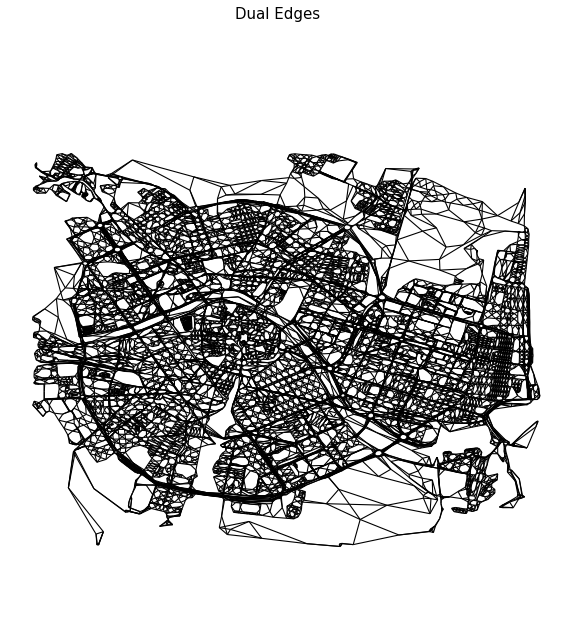

In [25]:
uf.plot_lines(edgesDual, bb = False, f = 10, title = 'Dual Edges')

## 2. add missing columns

In [26]:
nodesD = nodesDual.copy()
edgesD = edgesDual.copy()

In [27]:
#mapping columns in Dual graph 
def mapCol_Dual(n, e, param, name):
    e[name] = 0
    e[name] = e[name].astype('float')
    length = len(e.index)
    for i in range(0,length-1):
        pos = n.streetID[e.v[i]]
        v_w1 = n.loc[n['streetID'] == pos, param]
        e[name][i] = v_w1
    return e

In [31]:
# add parameters
mapCol_Dual(nodesD,edgesD, 'slopeCost', 'slopeCost')
mapCol_Dual(nodesD,edgesD, 'hasBikeP', 'hasBikeP')
mapCol_Dual(nodesD,edgesD, 'length', 'length2')
edgesD.head()

,u,v,length,geometry,deg,rad,slopeCost,hasBikeP,length2
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811,9.996,0.000,44.783
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797,22.802,0.000,98.874
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676,10.471,0.000,45.112
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014,16.096,0.000,56.985
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331,16.096,0.000,56.985


In [37]:
edgesD['key']=0

In [38]:
# add primal weights
mapCol_Dual(nodesD,edgesD, 'weightP1', 'weightP1')
mapCol_Dual(nodesD,edgesD, 'weightP2', 'weightP2')
mapCol_Dual(nodesD,edgesD, 'weightP3', 'weightP3')
edgesD.head()

,u,v,length,geometry,deg,rad,slopeCost,hasBikeP,length2,weightP1,weightP2,weightP3,key
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811,9.996,0.000,44.783,9.996,9.996,11.788,0
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797,22.802,0.000,98.874,22.070,22.802,26.757,0
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676,10.471,0.000,45.112,10.070,10.471,12.275,0
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014,16.096,0.000,56.985,12.720,16.096,18.376,0
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331,16.096,0.000,56.985,12.720,16.096,18.376,0


## 3. calculate parameter & weights

In [40]:
#create a angular confusion field 
edgesD['angConf'] = 0
edgesD['angConf'] = edgesD['angConf'].astype('float')

In [41]:
#createfunction to calculate angular confusion
def angConf(e):
    length = len(e.index)
    for i in range(0,length-1):   
        if e['deg'][i] > 2:
            rad = e['rad'][i]
            ang = math.sin(rad/2)**2
            e['angConf'][i] = 10*ang
        else:
            e['angConf'][i] = 0
    return e

In [42]:
edgesD = angConf(edgesD)

In [44]:
#weight 1: only angular confusion
edgesD['weightA1'] = edgesD['angConf']
edgesD.head()

,u,v,length,geometry,deg,rad,slopeCost,hasBikeP,length2,weightP1,weightP2,weightP3,key,angConf,weightA1
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811,9.996,0.000,44.783,9.996,9.996,11.788,0,6.191,6.191
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797,22.802,0.000,98.874,22.070,22.802,26.757,0,6.120,6.120
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676,10.471,0.000,45.112,10.070,10.471,12.275,0,5.526,5.526
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014,16.096,0.000,56.985,12.720,16.096,18.376,0,0.000,0.000
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331,16.096,0.000,56.985,12.720,16.096,18.376,0,3.810,3.810


In [46]:
#weight 2: angular confusion + length
edgesD['weightA2'] = edgesD['angConf']+edgesD['weightP1']
edgesD.head()

,u,v,length,geometry,deg,rad,slopeCost,hasBikeP,length2,weightP1,weightP2,weightP3,key,angConf,weightA1,weightA2
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811,9.996,0.000,44.783,9.996,9.996,11.788,0,6.191,6.191,16.187
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797,22.802,0.000,98.874,22.070,22.802,26.757,0,6.120,6.120,28.190
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676,10.471,0.000,45.112,10.070,10.471,12.275,0,5.526,5.526,15.596
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014,16.096,0.000,56.985,12.720,16.096,18.376,0,0.000,0.000,12.720
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331,16.096,0.000,56.985,12.720,16.096,18.376,0,3.810,3.810,16.530


In [47]:
#weight 3: angular and slope
edgesD['weightA3'] = edgesD['angConf']+edgesD['slopeCost']
edgesD.head()

,u,v,length,geometry,deg,rad,slopeCost,hasBikeP,length2,weightP1,weightP2,weightP3,key,angConf,weightA1,weightA2,weightA3
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811,9.996,0.000,44.783,9.996,9.996,11.788,0,6.191,6.191,16.187,16.187
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797,22.802,0.000,98.874,22.070,22.802,26.757,0,6.120,6.120,28.190,28.922
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676,10.471,0.000,45.112,10.070,10.471,12.275,0,5.526,5.526,15.596,15.997
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014,16.096,0.000,56.985,12.720,16.096,18.376,0,0.000,0.000,12.720,16.096
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331,16.096,0.000,56.985,12.720,16.096,18.376,0,3.810,3.810,16.530,19.907


In [66]:
#weight A4: calculate if there's bike path 
# if there is no bikepath, adding 4s to every 100m
#weight A4 = A3+cost (when no bikepath)
edgesD['weightA4'] = edgesD['angConf']+edgesD['weightP3']
edgesD.head()

,u,v,length,geometry,deg,rad,slopeCost,hasBikeP,length2,weightP1,weightP2,weightP3,key,angConf,weightA1,weightA2,weightA3,weightA4
0,31589,31590,84.819,"LINESTRING (-0.39249 39.46118, -0.39272 39.46061)",103.784,1.811,9.996,0.000,44.783,9.996,9.996,11.788,0,6.191,6.191,16.187,16.187,17.979
1,31584,31585,106.358,"LINESTRING (-0.40323 39.45509, -0.40357 39.45448)",102.940,1.797,22.802,0.000,98.874,22.070,22.802,26.757,0,6.120,6.120,28.190,28.922,32.877
2,31578,31579,27.869,"LINESTRING (-0.36351 39.47819, -0.36326 39.47816)",96.038,1.676,10.471,0.000,45.112,10.070,10.471,12.275,0,5.526,5.526,15.596,15.997,17.801
3,31566,31567,114.596,"LINESTRING (-0.39236 39.45517, -0.39354 39.45565)",0.812,0.014,16.096,0.000,56.985,12.720,16.096,18.376,0,0.000,0.000,12.720,16.096,18.376
4,31563,31567,61.524,"LINESTRING (-0.39306 39.45580, -0.39354 39.45565)",76.235,1.331,16.096,0.000,56.985,12.720,16.096,18.376,0,3.810,3.810,16.530,19.907,22.186


## 4. create dual graph

In [67]:
DualG = snf.get_dual_graph(nodesD,edgesD)

In [52]:
DualG.graph['crs'] = crs

In [53]:
DualG.graph['name'] = city_name

In [64]:
nodesD = nodesD.drop(columns=['intersecting'])

In [65]:
# gdf download
nodesD.crs = crs
nodesD.to_file(saving_path+'nodesD.shp', driver = 'ESRI Shapefile')
edgesD.crs = crs
edgesD.to_file(saving_path+'edgesD.shp', driver = 'ESRI Shapefile')

In [68]:
dill.dump_session('CreateDualGraphN1.db')